In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn as nn

import einops
%load_ext autoreload


from diffusers import AutoencoderKL
from torch.utils.data import DataLoader

from utils import  get_device
from data_preprocessing import preprocess_images,XrdDataset

import time
import uuid

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def create_experiment_id(model_name="transformer", notes="default"):
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    unique_id = uuid.uuid4().hex[:8]  # short unique hash
    return f"{timestamp}_{model_name}_{notes}_{unique_id}"

In [60]:
%autoreload 2

### Data Preparation

In [61]:
path = 'data'

In [91]:
# feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
dataset = XrdDataset(data_dir=path, feature_extractor=None)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
s = next(iter(dataloader))
 

In [92]:
print(f'mean: {s[0].mean()}')
print(f'std: {s[0].std()}')

mean: -0.00457920553162694
std: 0.06063685938715935


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


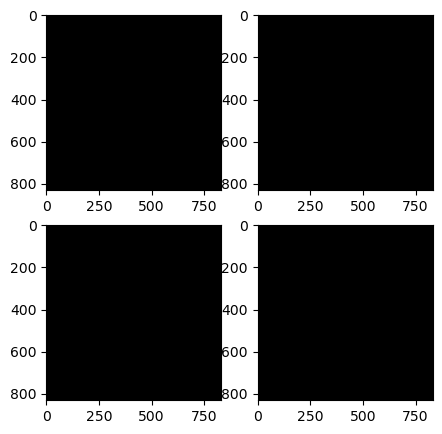

In [93]:

# conv_layer = nn.Conv2d(in_channels, out_channels,
#                     kernel_size=(F, F), stride=(S,S), 
#                     padding=(1, 2), padding_mode='zeros')
sample = s.clone()
sample.shape
sample = sample.repeat((1, 3, 1, 1))
sample = sample.cpu().detach().numpy()

fig, ax = plt.subplots(2, 2, figsize=(5, 5))

ax[0, 0].imshow(sample[0].transpose(1, 2, 0))
ax[0, 1].imshow(sample[1].transpose(1, 2, 0))
ax[1, 0].imshow(sample[2].transpose(1, 2, 0))
ax[1, 1].imshow(sample[3].transpose(1, 2, 0))



(5, 3, 832, 832)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


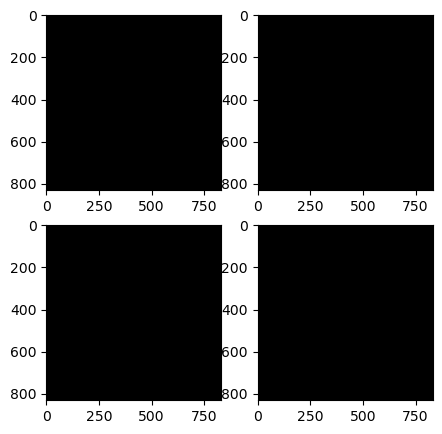

In [9]:
for batch in dataloader:
    pixel_values = batch
    print(pixel_values.shape)
    

Loading data/mfxl1027522_r0030_peaknet.0069.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0070.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0074.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0073.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0071.zarr/images
torch.Size([1, 40, 3, 224, 224])
Loading data/mfxl1027522_r0030_peaknet.0072.zarr/images
torch.Size([1, 40, 3, 224, 224])


### Model Instantiation

In [11]:
# Load the autoencoder model.
device = get_device()
url = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/blob/main/vae-ft-mse-840000-ema-pruned.safetensors"
vae = AutoencoderKL.from_single_file(url)
vae.train()  # Set model to training mode.
vae.to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)
criterion = nn.MSELoss()


In [12]:
vae(sample.to(device)).shape

NameError: name 'sample' is not defined

In [73]:
sample.shape

torch.Size([1, 3, 224, 224])

In [69]:
decoder = vae(sample.to(device))

In [72]:
output =vae.forward(sample.to(device),sample_posterior=True)

RuntimeError: MPS backend out of memory (MPS allocated: 18.11 GB, other allocations: 14.09 MB, max allowed: 18.13 GB). Tried to allocate 24.50 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [19]:
decoder.sample.shape
output = decoder.sample.cpu().detach().numpy()

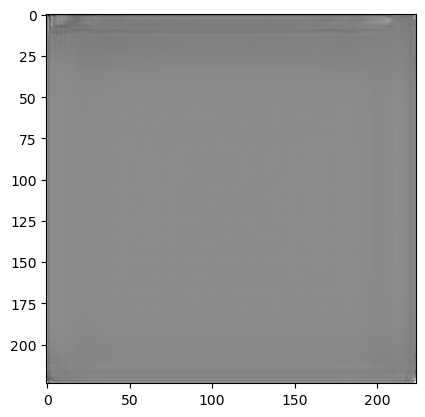

In [22]:
# plot image
plt.imshow(output[0,1,:,:], cmap='gray')

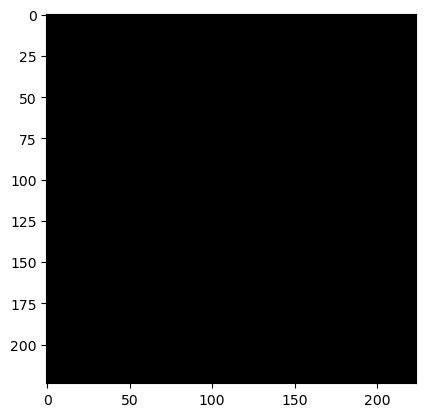

In [23]:
plt.imshow(sample[0,2,:,:], cmap='gray')

In [ ]:
import torch